# US Household displacement in disasters: Random forests

## General background

In 2022, more than 1.3% of the adult population (3.3M) in the United States was displaced by disasters [(AP News)](https://apnews.com/article/natural-disasters-indiana-florida-climate-and-environment-0bfdab41b233feba55e08382a0594258).

This notebook investigates the public use files (PUF) from the [**United States Household Pulse Survey**](https://www.census.gov/programs-surveys/household-pulse-survey.html). Information regarding displacement following disasters was introduced from Week 52. The availability of microdata allows an exploration of various factors that may be associated longer displacement durations.


## Notebook scope
This notebook employs multiple classification tree models using Random Forest. This method is appealing due its ability to yield reasonably good predictions with relatively small datasets for similar applications, as well as the possibility to explain variable importance within the model using SHAP values.

The hyperparameter tuning step takes several hours. To load the best fit model, you can scroll to the 'Load pre-saved model' section

## Configuration

* Load dependencies

* Load configuration for figures/plotting

* Load custom methods to process data

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from parsers.parse_data_dictionary import parse_data_dictionary
from parsers.parse_puf_files import parse_puf_files, custom_puf_handling
from plotters.plot_trees import plot_feature_importance
from plotters.plot_metrics import plot_roc_auc, plot_confusion_matx
from util.plot import plot_config

# Add dependencies - running the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
# Add dependencies - evaluating the model
from sklearn.metrics import classification_report
# Add dependencies - explainable AI / SHAP
import shap

plot_config(theme="derisc")

Using theme: derisc


## Read and parse data

* Read a data dictionary (`data_dict`), which helps parse the variables available in the PUF and provides human-friendly string descriptions

* Read multiple PUF files and combine into one DataFrame (`puf`)

* Displace the overall displacement rate based on the data (with household weights applied)

In [4]:
# Read data dictionary
data_folder = os.path.join("data")
data_dict_path = os.path.join(data_folder, "Data_Dictionary.xlsx")
data_dict = parse_data_dictionary(data_dict_path, drop_bad=True).set_index('Variable')

# Print available factors
print(f"Potentially relevant factors for processing: {data_dict.index.values}")

# Preview
data_dict.head(5)

Potentially relevant factors for processing: ['TBIRTH_YEAR' 'RHISPANIC' 'RRACE' 'EEDUC' 'MS' 'GENID_DESCRIBE'
 'THHLD_NUMPER' 'THHLD_NUMKID' 'THHLD_NUMADLT' 'KIDS_LT5Y' 'KIDS_5_11Y'
 'KIDS_12_17Y' 'TENROLLPUB' 'TENROLLPRV' 'TENROLLHMSCH' 'ANYWORK'
 'KINDWORK' 'SETTING' 'TWDAYS' 'FRMLA_YN' 'ND_DISPLACE' 'ND_TYPE1'
 'ND_TYPE2' 'ND_TYPE3' 'ND_TYPE4' 'ND_TYPE5' 'ND_HOWLONG' 'ND_DAMAGE'
 'ND_FDSHRTAGE' 'ND_WATER' 'ND_ELCTRC' 'ND_UNSANITARY' 'ANXIOUS' 'WORRY'
 'INTEREST' 'DOWN' 'SEEING' 'HEARING' 'REMEMBERING' 'MOBILITY' 'SELFCARE'
 'UNDERSTAND' 'TENURE' 'TRENTAMT' 'LIVQTRRV' 'INCOME' 'EST_ST' 'EST_MSA'
 'HWEIGHT' 'REGION']


,Type,Name,Values,Conversion
Variable,,,,
TBIRTH_YEAR,Discrete,Birth year,1934 to 2004,{'1934 to 2004': '1934 to 2004'}
RHISPANIC,Nominal,Hispanic origin,1) No\n2) Yes,"{1: 'No', 2: 'Yes'}"
RRACE,Nominal,Race,1) White\n2) Black\n3) Asian\n4) Other/Mixed,"{1: 'White', 2: 'Black', 3: 'Asian', 4: 'Other..."
EEDUC,Ordinal,Educational attainment,1) Less than high school\n2) Some high school\...,"{1: 'Less than high school', 2: 'Some high sch..."
MS,Nominal,Marital status,1) Now married\n2) Widowed\n3) Divorced\n4) Se...,"{1: 'Now married', 2: 'Widowed', 3: 'Divorced'..."


In [5]:
# Locate folder where data is stored
puf_folder = PUF_FOLDER # Save the zipped PUF files from the HPS in a known location and reference the path here
assert os.path.exists(puf_folder), f"Could not locate {puf_folder}"

# Locate folder to write any outputs
img_folder = os.path.join("img")

# Read PUF files
puf = parse_puf_files(puf_folder)

# Preview
print(f"Found {puf.shape[0]:,.0f} records")
puf.head(5)

Setting bad_vals ([-88, -99]) = NaN
Found 826,941 records


,SCRAM,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,RHISPANIC,...,ND_MED,HLTH_MHCHLD1,HLTH_MHCHLD2,HLTH_MHCHLD3,HLTH_MHCHLD4,HLTH_MHCHLD5,HLTH_MHCHLD6,HLTH_MHCHLD7,HLTH_MHCHLD8,HLTH_MHCHLD9
0,V520000001,52.0,44.0,NaN,1.0,297.631871,1123.798115,1968.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,V520000002,52.0,5.0,NaN,2.0,544.644346,1009.342253,1959.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,V520000003,52.0,48.0,NaN,2.0,187.423803,346.468149,1946.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,V520000004,52.0,11.0,47900.0,2.0,116.768607,199.033089,1984.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,V520000005,52.0,28.0,NaN,2.0,700.047941,1329.911657,1963.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Read in area data
area_path = os.path.join(data_folder, "Area_Attributes.xlsx")
msa_field, state_field = "EST_MSA", "EST_ST"
area_cats = [msa_field, state_field]
areas = dict.fromkeys(area_cats)
for area_cat in area_cats:
    areas[area_cat] = pd.read_excel(area_path, sheet_name=area_cat).set_index(area_cat)

# Read and append area dictionary
dict_sheet = "Data Dictionary"
area_dict = pd.read_excel(area_path, sheet_name=dict_sheet).set_index('Variable')
data_dict = pd.concat([data_dict, area_dict], axis=0)

# Determine columns to be added
all_cols = np.array([areas[area_cat].columns for area_cat in areas])
area_cols  = list(set.union(*map(set, all_cols)))
print(f"Will add area attributes: {area_cols}")

# Get unique values
msas = puf[msa_field].dropna().unique()
states = puf[state_field].dropna().unique()

# Append area attributes
puf[area_cols] = float('nan')
for col in area_cols:
    if col in areas[state_field].columns:
        for state in states:
            idx = puf[state_field] == state
            puf.loc[idx, col] = areas[state_field].loc[state, col]
    if col in areas[msa_field].columns:
        for msa in msas:
            jdx = puf[msa_field] == msa
            puf.loc[jdx, col] = areas[msa_field].loc[msa, col]

# Preview
puf.head(5)

Unknown extension is not supported and will be removed
Conditional Formatting extension is not supported and will be removed
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Will add area attributes: ['DISASTERS_2021-2023', 'SATISFACTION_HOME_2021', 'UNEMPLOYMENT_2022', 'RATE_HOMEOWNER_2022', 'POPULATION_TREND_10YR', 'METRO_AREA', 'POPULATION_2020', 'VACANCY_HOMEOWNER_2022', 'STATE', 'VACANCY_RENTAL_2022', 'SATISFACTION_NGBD_2021']


,SCRAM,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,RHISPANIC,...,SATISFACTION_HOME_2021,UNEMPLOYMENT_2022,RATE_HOMEOWNER_2022,POPULATION_TREND_10YR,METRO_AREA,POPULATION_2020,VACANCY_HOMEOWNER_2022,STATE,VACANCY_RENTAL_2022,SATISFACTION_NGBD_2021
0,V520000001,52.0,44.0,NaN,1.0,297.631871,1123.798115,1968.0,2.0,1.0,...,NaN,3.2,65.8,0.040216,NaN,1096345.0,0.6,Rhode Island,4.6,NaN
1,V520000002,52.0,5.0,NaN,2.0,544.644346,1009.342253,1959.0,2.0,1.0,...,NaN,3.3,66.8,0.031565,NaN,3014195.0,1.5,Arkansas,10.5,NaN
2,V520000003,52.0,48.0,NaN,2.0,187.423803,346.468149,1946.0,2.0,1.0,...,0.884599,3.9,63.6,0.158090,NaN,29232474.0,0.8,Texas,7.9,NaN
3,V520000004,52.0,11.0,47900.0,2.0,116.768607,199.033089,1984.0,2.0,1.0,...,0.921331,3.0,66.2,0.121192,"Washington-Arlington-Alexandria, DC-VA-MD-WV M...",6366679.0,0.6,District of Columbia,5.3,0.928345
4,V520000005,52.0,28.0,NaN,2.0,700.047941,1329.911657,1963.0,2.0,1.0,...,NaN,3.9,73.1,-0.004177,NaN,2958141.0,0.6,Mississippi,8.4,NaN


In [7]:
# Estimate percentage of households that were displaced
criteria = (puf.ND_DISPLACE == 1)
n_households = puf.HWEIGHT.sum()
n_displaced_households = puf[criteria].HWEIGHT.sum()
print(f"Estimated a displacement rate of {(n_displaced_households/n_households):.2%}")

Estimated a displacement rate of 1.20%


## Custom data processing

* Binning continuous/discrete factors to be ordinal

* Creating factors to represent protracted displacement and return

* Creating dummy variables for nominal data

In [8]:
# Implement custom data handling
puf, data_dict = custom_puf_handling(puf, data_dict)

# Export processed data subset for dashboard
criteria = (puf.ND_DISPLACE == 1) 
# puf[criteria].to_csv("displaced_households.csv", index=False)

# Preview
puf[criteria].head(5)

Added new columns: ['HAZARD_TYPE', 'AGE_BIN', 'HH_BIN', 'RENT_BIN', 'INCOME_PER', 'DWELLTYPE', 'TENURE_STATUS', 'RMINORITY', 'SCHOOLENROLL', 'LIVQTR_OTHER', 'LIVQTR_MOBILE', 'LIVQTR_SINGLE', 'LIVQTR_MULTI', 'RETURNED', 'PROTRACTED', 'RECOVERY', 'PHASE', 'PHASE_RETURN', 'RETURN_1', 'RETURN_2', 'RETURN_3']


,SCRAM,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,RHISPANIC,...,LIVQTR_SINGLE,LIVQTR_MULTI,RETURNED,PROTRACTED,RECOVERY,PHASE,PHASE_RETURN,RETURN_1,RETURN_2,RETURN_3
7,V520000008,52.0,12.0,NaN,2.0,10141.479843,18633.438797,1994.0,2.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
70,V520000071,52.0,4.0,NaN,4.0,3504.757175,6529.976342,1950.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
108,V520000109,52.0,42.0,37980.0,1.0,801.677778,2856.430494,1972.0,2.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
110,V520000111,52.0,22.0,NaN,2.0,895.045567,1686.648972,1987.0,2.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
382,V520000383,52.0,42.0,NaN,1.0,4276.797681,7619.255295,1958.0,2.0,1.0,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Split data and apply weights

# Feature selection
dependent = "PHASE_RETURN" # options: RETURNED, PROTRACTED, RETURN_1, RETURN_2, RETURN_3, ND_HOWLONG, PHASE
independents = ['ND_DAMAGE',
                'ND_WATER', 'ND_ELCTRC', 'ND_UNSANITARY', 'ND_FDSHRTAGE', 
                'TENURE_STATUS', # 'TENURE',
                'HH_BIN', 'SCHOOLENROLL',
                'INCOME_PER', # 'INCOME',
                'RRACE',
                'DWELLTYPE', # 'LIVQTR_OTHER', 'LIVQTR_MOBILE, 'LIVQTR_SINGLE', 'LIVQTR_MULTI', # 'LIVQTRRV',
                'HAZARD_TYPE',
                'UNEMPLOYMENT_2022',
                'DISASTERS_2021-2023',
                # 'SATISFACTION_NGBD_2021',
                # 'SATISFACTION_HOME_2021',
                'RATE_HOMEOWNER_2022',
                'VACANCY_HOMEOWNER_2022', 'VACANCY_RENTAL_2022', 'POPULATION_TREND_10YR', # 'POPULATION_2020',
                'MS', 'RHISPANIC', # 'RMINORITY',
                'ANYWORK', 'AGE_BIN','EEDUC', 'MOBILITY', # 'RENT_BIN'
               ]
weights = "HWEIGHT"

# Choose class names
class_names = data_dict.loc[dependent, 'Conversion']

# Get data subset
data = puf[criteria].dropna(subset=[dependent]+independents).copy()
n_all, n_safe = puf[criteria].shape[0], data.shape[0]
print(f"Dropping {(n_all-n_safe):,.0f} rows with NaN values of {n_all:,.0f} records ({(n_safe/n_all):.1%} retained)")

# Arrange data
y = data[dependent] # Target variable
X = data[independents] # Features
w = data[weights].div(50).astype(int) # Weights
n_independents = len(independents)

# Split dataset into training set and test set
seed = 16
p_testing = 0.2
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=p_testing, random_state=seed, stratify=y) 

# Expand by weights
from util.data import expand_train_test_split_by_weights
X_train, y_train = expand_train_test_split_by_weights(X_train, y_train, w_train)
X_test, y_test = expand_train_test_split_by_weights(X_test, y_test, w_test)

# Apply class balancing technique
method = "SMOTE" # Options: SMOTE, invHist
sample_weight = None
if method == "SMOTE":
  from imblearn.over_sampling import SMOTE
  smote_seed = 3
  sm = SMOTE(random_state=smote_seed, sampling_strategy='not majority')
  X_train, y_train = sm.fit_resample(X_train, y_train)
elif method == "invHist":
  from sklearn.utils.class_weight import compute_sample_weight
  sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)
else:
  raise NameError(f'Method of {method} not known')

Dropping 1,434 rows with NaN values of 7,556 records (81.0% retained)
Expanded 4,897 rows into 231,197 using custom weights
Expanded 4,897 rows into 231,197 using custom weights
Expanded 1,225 rows into 53,886 using custom weights
Expanded 1,225 rows into 53,886 using custom weights


## Fitting random forest models

TODO

suggested max_depth range=[3, 5]


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Best hyperparameters: {'max_depth': 7, 'n_estimators': 900}


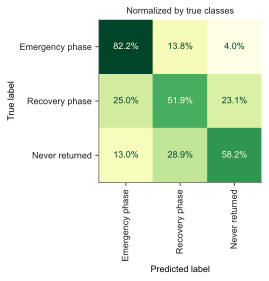

                 precision    recall  f1-score   support

Emergency phase       0.90      0.82      0.86     37501
 Recovery phase       0.41      0.52      0.46      9585
 Never returned       0.52      0.58      0.55      6800

       accuracy                           0.74     53886
      macro avg       0.61      0.64      0.62     53886
   weighted avg       0.77      0.74      0.75     53886



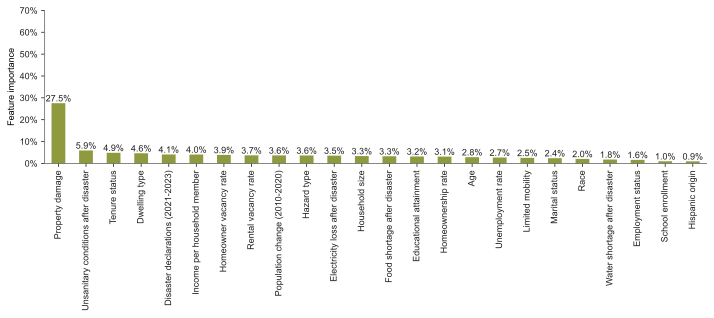

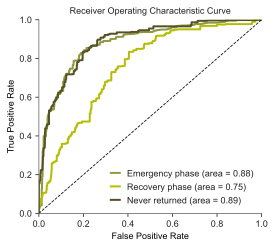

In [8]:
# Hyperparameter tuning-  Choose parameters
min_depth = round(np.log(n_independents)) 
max_depth = round(np.sqrt(n_independents)) 
print(f"suggested max_depth range=[{min_depth}, {max_depth}]")
param_grid = {
              'max_depth': [3, 4, 5, 6, 7],
              'n_estimators': [300, 500, 700, 900],
              }
criterion = 'gini'
random_seed = 99

# Create a random forest classifier
rf = RandomForestClassifier(criterion=criterion, random_state=random_seed)

# Use grid search to find the best hyperparameters
np_seed = 24
np.random.seed(np_seed) # may be required to get stable results from from GridSearchCV
cv = 10
score = 'roc_auc_ovr' # 'f1_macro' # see: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
score = {'auc_ovr': 'roc_auc_ovr', 'f1_macro': 'f1_macro'}
grid_search = GridSearchCV(rf,
                           param_grid, 
                           cv=cv,
                           scoring=score,
                           n_jobs=4,
                           refit='f1_macro',
                           return_train_score=True,
                           )

# Fit the random search object to the data
grid_search.fit(X_train, y_train.values.ravel(order='c'))

# Create a variable for the best model
best_rf = grid_search.best_estimator_.fit(X_train, y_train)
# Print the best hyperparameters
print('Best hyperparameters:',  grid_search.best_params_)

# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
fig, axs = plot_confusion_matx(y_test, y_pred, class_names, norm='true')
plt.show()

# Test predictions
print(classification_report(y_test, y_pred, target_names=class_names.values()))

# Create a series containing feature importances from the model and feature names from the training data (naive)
fig, ax = plt.subplots(figsize=(10,4.5))
plot_feature_importance(best_rf.feature_importances_, independents, data_dict, ax, ylim=(0,0.7))
fig.tight_layout()
# fig.savefig(os.path.join(img_folder, f'Forest_Importance_{dependent}.png'), dpi=200, facecolor='w')
plt.show()

# Create ROC/AUC plot
fig, ax = plt.subplots(figsize=(4,3.5))
plot_roc_auc(best_rf, X_test, y_test, class_names, ax)
plt.show()

In [9]:
# Evaluate performance of candidate models more holistically
result_params = ['param_max_depth', 'param_n_estimators'] 
result_columns = ['mean_test', 'std_test', 'mean_train']
score_keys = list(score.keys())

results = pd.DataFrame(grid_search.cv_results_)
for col in result_columns:
    score_cols = [f'{col}_{key}' for key in score_keys]
    results[col] = results[score_cols].mean(axis=1)

results.sort_values(by=result_columns, ascending=False)[result_columns + result_params].head(20)

,mean_test,std_test,mean_train,param_max_depth,param_n_estimators
19,0.868238,0.011325,0.881863,7,900
18,0.867426,0.011215,0.881339,7,700
17,0.867342,0.011401,0.881447,7,500
16,0.866792,0.011826,0.881090,7,300
14,0.829908,0.011991,0.843120,6,700
15,0.829893,0.011867,0.843270,6,900
13,0.829480,0.011538,0.842636,6,500
12,0.829116,0.011548,0.842065,6,300
11,0.789149,0.012159,0.799492,5,900
10,0.788940,0.012397,0.799545,5,700


{'max_depth': 7, 'n_estimators': 900}


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


                 precision    recall  f1-score   support

Emergency phase       0.90      0.82      0.86     37501
 Recovery phase       0.41      0.52      0.46      9585
 Never returned       0.52      0.58      0.55      6800

       accuracy                           0.74     53886
      macro avg       0.61      0.64      0.62     53886
   weighted avg       0.77      0.74      0.75     53886



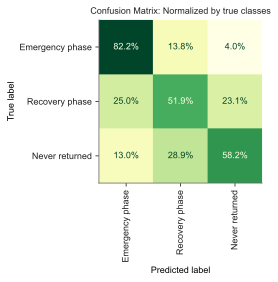

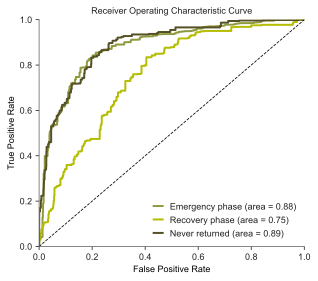

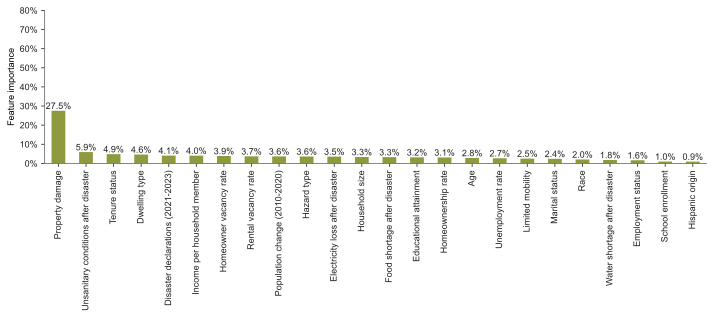

In [12]:
# Investigate another forest
idx = 19
params = grid_search.cv_results_['params'][idx]
print(params)
forest = RandomForestClassifier(criterion=criterion, random_state=random_seed, **params)
model = forest.fit(X_train, y_train, sample_weight=sample_weight)

# Evaluate performance
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=class_names.values()))

# Create the confusion matrix
fig, ax = plt.subplots(figsize=(4.5,4))
plot_confusion_matx(y_test, y_pred, class_names, norm='true', ax=ax)
fig.tight_layout()
ax.set_title('Confusion Matrix: Normalized by true classes')
fig.savefig(os.path.join(img_folder, f'Forest_Confusion_{dependent}.png'), dpi=200, facecolor='w')
plt.show()

# Create ROC/AUC plot
fig, ax = plt.subplots(figsize=(4.5,4))
plot_roc_auc(forest, X_test, y_test, class_names, ax=ax)
fig.tight_layout()
fig.savefig(os.path.join(img_folder, f'Forest_ROC_{dependent}.png'), dpi=200, facecolor='w')
plt.show()

# Create a series containing feature importances from the model and feature names from the training data (naive) -- see next cells for SHAP values
fig, ax = plt.subplots(figsize=(10,4.5))
plot_feature_importance(model.feature_importances_, independents, data_dict, ax, ylim=(0,0.8))
fig.tight_layout()
plt.show()

## Load pre-saved model and get SHAP values

In [10]:
# load the model from disk
import pickle
filename = "best_rf.sav"
loaded_model = pickle.load(open(filename, 'rb'))

loaded_model

RandomForestClassifier(max_depth=7, n_estimators=900, random_state=99)

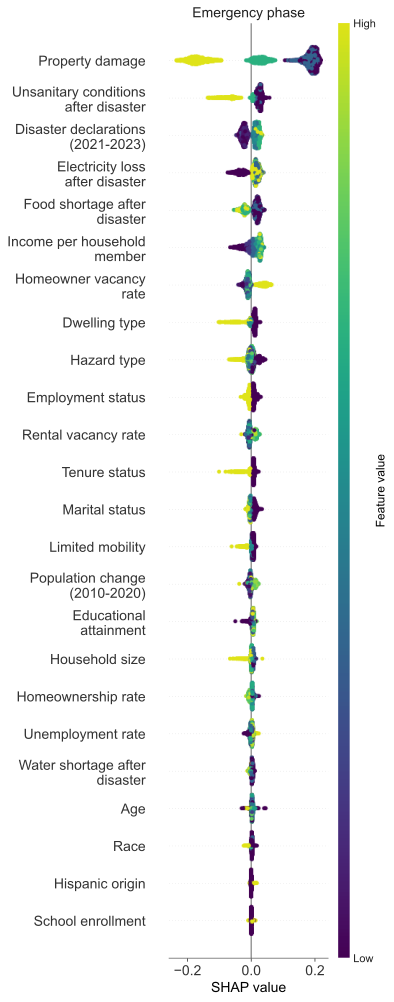

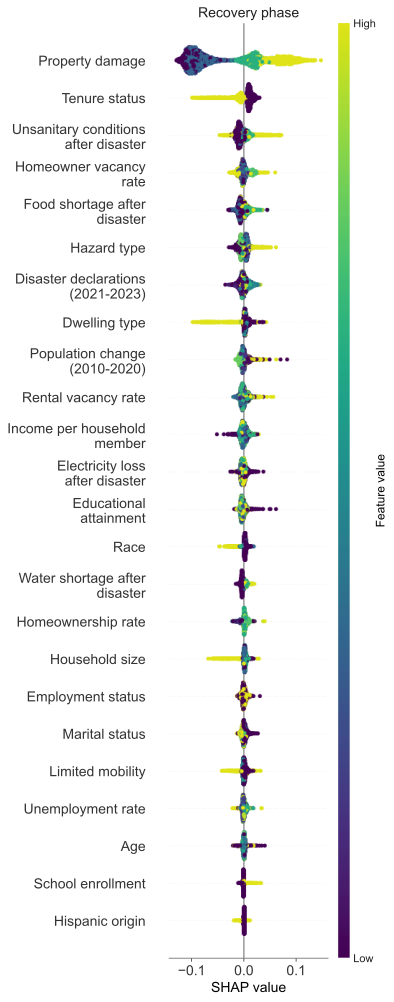

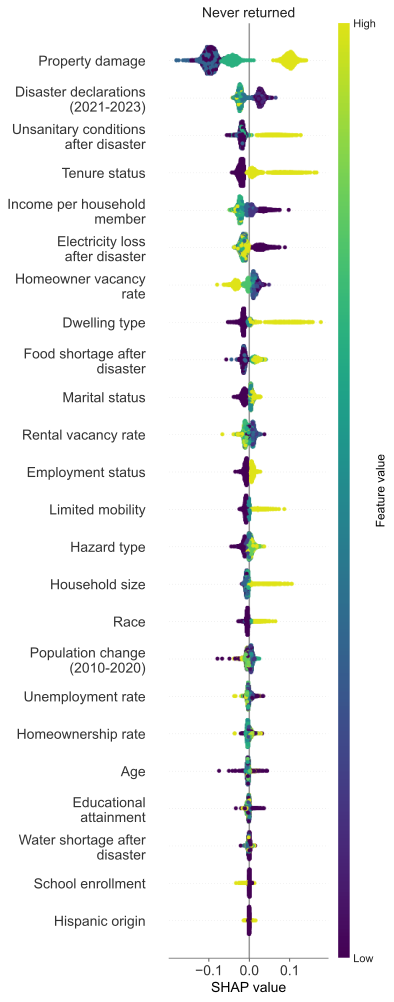

In [12]:
# TreeExplainer
rf_shap = shap.TreeExplainer(loaded_model).shap_values(X) # NOTE: The first few cells need to be run to get X
# rf_shap_interaction = shap.TreeExplainer(best_rf).shap_interaction_values(X)

import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


cmap = plt.get_cmap('viridis')
new_cmap = truncate_colormap(cmap, 0, 0.95)

import textwrap

strs = data_dict.loc[X.columns, 'Name'].values
wrap_strs = [textwrap.fill(str, 21) for str in strs]

fs = 14
# Plot beeswarm
for i in range(3):
    class_name = class_names[i]
    fig = shap.summary_plot(rf_shap[i], X.values, feature_names=wrap_strs, plot_size=(5.5,14),
                      auto_size_plot=None, title=class_name, max_display=n_independents, show=False, cmap=new_cmap)
    ax = plt.gca()
    ax.set_title(class_name, fontsize=fs)
    ax.set(xlabel='SHAP value') 
    ax.tick_params(axis='both', which='major', labelsize=fs) 
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    plt.tight_layout()
    plt.savefig(os.path.join(img_folder, f'Forest_SHAP_{class_name}'), dpi=200, facecolor='w')
    plt.show()